Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

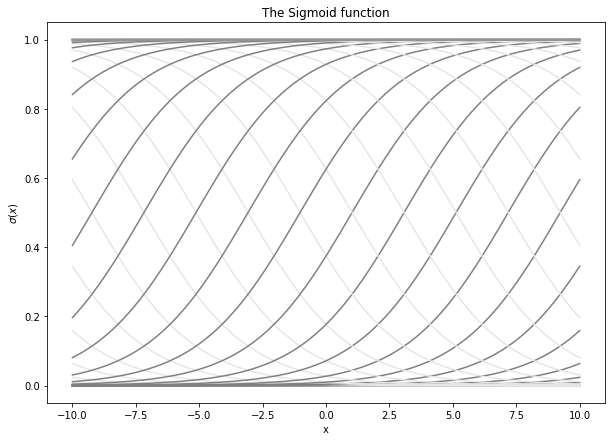

In [12]:
# Just a pretty picture
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

# Plot the function
x_plot = np.linspace(-10, 10, 100)
n = 40
M = np.linspace(0.5, 0.5, n)
B = np.linspace(-20, 20, n)
for m, b in zip(M, B):
  plt.plot(x_plot, sigmoid(-m*x_plot+b),c="0.9")
  plt.plot(x_plot, sigmoid(m*x_plot+b),c="0.5")

plt.xlabel('x'); plt.ylabel('$\sigma(x)$')
plt.title('The Sigmoid function')

plt.show()

In [68]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [70]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')
print(df.shape)
df.head()

# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

# Cast Date from 'str' to 'datetime64[ns]'
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# A generic function which will one hot encode a list of columns
# returns a new DataFrame
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode(data, cols):
  enc = OneHotEncoder(sparse=False)
  onehot = enc.fit_transform(data[cols])
  onehot = pd.DataFrame(onehot, columns=enc.get_feature_names(cols))

  data = data.drop(cols, axis=1)
  data = data.reset_index().drop(labels='index', axis=1)
  return pd.concat([data, onehot], axis=1)
df = one_hot_encode(df, ['Burrito'])

# One hot encode the ingredient columns partially filled with X's?

# Merge any completed feature engineering to the end here
df

(423, 66)


,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,Burrito_Asada,Burrito_California,Burrito_Carnitas,Burrito_Other,Burrito_Surf & Turf
0,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,1.0,0.0,0.0,0.0
1,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,1.0,0.0,0.0,0.0
2,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,1.0,0.0,0.0
3,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,0.0,0.0,0.0,0.0
4,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,2019-08-27,NaN,NaN,NaN,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,0.0,1.0,0.0
417,2019-08-27,NaN,NaN,NaN,6.00,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.0,0.0,0.0,1.0,0.0
418,2019-08-27,NaN,NaN,NaN,7.90,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,1.0,0.0,0.0,0.0
419,2019-08-27,NaN,NaN,NaN,7.90,3.0,NaN,NaN,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.0,0.0,0.0,1.0,0.0


In [72]:
# Delete all nulls while retaining the most data

# Delete all columns with 30 nulls or more (which is optimal)
# And then remove all rows with nulls
# This retains 61.25% of the original values

# Remove any columns with 30 or more null values
max_nulls = 30
trash_columns = []
for col in df.columns:
  nulls = df[col].isnull().sum()
  if nulls >= max_nulls:
    trash_columns.append(col)
df = df.drop(columns=trash_columns)

# Remove the remaining rows which have null values
df = df.dropna()

In [ ]:
# Explore how many nulls per column is optimal before deleting the column

# Remove columns which have too many null values
def get_values(data):
  area = data.size
  nulls = data.isnull().sum().sum()
  return area - nulls

print('For a maximum nulls per column, and then deleting '
      'all rows and columns above that threshold, '
      'what percentage of values are retained?')
print('Original shape =',df.shape)
print('Max_nulls: Value retention')
for max_nulls in range(0,209,10):
  values_0 = get_values(df)
  trash_columns = []
  for col in df.columns:
    nulls = df[col].isnull().sum()
    if nulls >= max_nulls:
      trash_columns.append(col)
  test = df.drop(columns=trash_columns)

  # Remove the remaining rows which have null values
  test = test.dropna()
  values_f = get_values(test)
  print(max_nulls,'=',test.shape,'=',format(100*values_f/values_0,'.2f')+'%')


For a maximum nulls per column, and then deleting all rows and columnsabove that threshold, what percentage of values are retained?
Original shape = (421, 59)
Max_nulls: Value retention
0 = (421, 0) = 0.00%
10 = (396, 11) = 53.53%
20 = (391, 12) = 57.66%
30 = (356, 14) = 61.25%
40 = (356, 14) = 61.25%
50 = (356, 14) = 61.25%
60 = (356, 14) = 61.25%
70 = (356, 14) = 61.25%
80 = (356, 14) = 61.25%
90 = (356, 14) = 61.25%
100 = (356, 14) = 61.25%
110 = (356, 14) = 61.25%
120 = (356, 14) = 61.25%
130 = (356, 14) = 61.25%
140 = (251, 15) = 46.27%
150 = (249, 17) = 52.02%
160 = (249, 17) = 52.02%
170 = (249, 17) = 52.02%
180 = (249, 17) = 52.02%
190 = (249, 17) = 52.02%
200 = (249, 17) = 52.02%


In [88]:
# Print the number of unique values in each column
print('Column = Unique Values')
for column in df.columns:
  cardinality = len(df[column].unique())
  print(column,'=',cardinality)

Column = Unique Values
Date = 151
Cost = 88
Hunger = 24
Tortilla = 17
Temp = 16
Meat = 23
Fillings = 22
Meat:filling = 22
Uniformity = 26
Salsa = 27
Synergy = 26
Wrap = 21
Great = 2
Burrito_Asada = 2
Burrito_California = 2
Burrito_Carnitas = 2
Burrito_Other = 2
Burrito_Surf & Turf = 2


In [74]:
# Function for doing the same Train/validate/test split on any set of columns.
# Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
def train_val_test(data):
  train = data[df['Date'].dt.year <= 2016]
  val   = data[df['Date'].dt.year == 2017]
  test  = data[df['Date'].dt.year >= 2018]
  return (train, val, test)

In [75]:
train, val, test = train_val_test(df)
print(f'shape of df = {df.shape}')
print('shape of train, vald, test =', train.shape, val.shape, test.shape)

shape of df = (356, 18)
shape of train, vald, test = (250, 18) (74, 18) (32, 18)


In [91]:
# Create y_train, y_val and y_test
target  = 'Great'
y_train, y_val, y_test = train_val_test(df[target])
# y = np.expand_dims(y, axis=1)  # if you want the shape to be (n, 1)
print('shape of y_train, y_val, y_test =', y_train.shape, y_val.shape, y_test.shape)

shape of y_train, y_val, y_test = (250,) (74,) (32,)


In [84]:
# Format a float into a percentage
def float_to_percent(float_num, decimal_places):
  return format(100*float_num, f'.{decimal_places}f')+'%'

# Make a formatted accuracy string
from sklearn.metrics import accuracy_score
def format_accuracy(y_data, y_pred):
  accuracy = accuracy_score(y_data, y_pred)
  return float_to_percent(float(accuracy), 1)

In [89]:
# The accuracy score of the baseline
majority_class = y_train.mode()[0]

train_pred = np.full(y_train.shape, majority_class)
train_baseline = format_accuracy(y_train, train_pred)
print(f'training baseline accuracy = {train_baseline}')

val_pred = np.full(y_val.shape, majority_class)
val_baseline = format_accuracy(y_val, val_pred)
print(f'validation baseline accuracy = {val_baseline}')

test_pred = np.full(y_test.shape, majority_class)
test_baseline = format_accuracy(y_test, test_pred)
print(f'testing baseline accuracy = {test_baseline}')

training baseline accuracy = 61.6%
validation baseline accuracy = 55.4%
testing baseline accuracy = 40.6%


In [90]:
# Choose compatible features
X = df.select_dtypes(exclude=['object', 'datetime64[ns]'])
X = X.drop(columns=[target])
print('shape of df and X =', df.shape, X.shape)

X_train, X_val, X_test = train_val_test(X)
print('shape of X_train, X_val, X_test =', X_train.shape, X_val.shape, X_test.shape)

shape of df and X = (356, 18) (356, 16)
shape of X_train, X_val, X_test = (250, 16) (74, 16) (32, 16)


In [109]:
# Make some linear models with some k best features
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

for k in range(1,len(X_train.columns)):
  # Get SelectKBest Features
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)

  # Make a linear model
  model = LinearRegression()
  model.fit(X_train_selected, y_train)

  # Make prediction on validation data
  X_val_selected = selector.transform(X_val)
  y_predict = model.predict(X_val_selected)
  # y_predict must be cast to a boolean
  y_predict = y_predict.round() == 1

  # Get and print the MAE
  accuracy = format_accuracy(y_val, y_predict)
  print(f'{accuracy} - Best {k} Linear Model')

78.4% - Best 1 Linear Model
81.1% - Best 2 Linear Model
89.2% - Best 3 Linear Model
91.9% - Best 4 Linear Model
89.2% - Best 5 Linear Model
89.2% - Best 6 Linear Model
87.8% - Best 7 Linear Model
86.5% - Best 8 Linear Model
89.2% - Best 9 Linear Model
87.8% - Best 10 Linear Model
79.7% - Best 11 Linear Model
78.4% - Best 12 Linear Model
78.4% - Best 13 Linear Model
77.0% - Best 14 Linear Model
77.0% - Best 15 Linear Model


In [115]:
# Use scikit-learn for logistic regression.
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

for k in range(1,len(X_train.columns)):
  # Get SelectKBest Features
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)

  # Make a logistic model
  model = LogisticRegression(solver='lbfgs')
  model.fit(X_train_selected, y_train)

  # Make prediction on validation data
  X_val_selected = selector.transform(X_val)
  y_predict = model.predict(X_val_selected)

  # Get and print the MAE
  accuracy = format_accuracy(y_val, y_predict)
  print(f'{accuracy} - Best {k} Logistic Model')

78.4% - Best 1 Logistic Model
83.8% - Best 2 Logistic Model
85.1% - Best 3 Logistic Model
93.2% - Best 4 Logistic Model
87.8% - Best 5 Logistic Model
91.9% - Best 6 Logistic Model
91.9% - Best 7 Logistic Model
87.8% - Best 8 Logistic Model
87.8% - Best 9 Logistic Model
89.2% - Best 10 Logistic Model
85.1% - Best 11 Logistic Model
85.1% - Best 12 Logistic Model
83.8% - Best 13 Logistic Model
83.8% - Best 14 Logistic Model
82.4% - Best 15 Logistic Model


In [119]:
# Accuracies for all models on testing data
from sklearn.metrics import accuracy_score

print('How well can various models predict which burritos are "Great"?')

# Baseline Model
def baseline():
  majority_class = y_train.mode()[0]
  test_pred = np.full(y_test.shape, majority_class)
  test_baseline = format_accuracy(y_test, test_pred)
  print(f'{test_baseline} - Baseline accuracy')
baseline()

# Best K Feature Linear Model
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
def best_k_linear(k=k):
  # Get SelectKBest Features
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)

  # Make a linear model
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  
  # Make prediction on test data
  X_test_selected = selector.transform(X_test)
  y_predict = model.predict(X_test_selected)
  # y_predict must be cast to a boolean
  y_predict = y_predict.round() == 1

  # Get and print the MAE
  accuracy = format_accuracy(y_test, y_predict)
  print(f'{accuracy} - Best {k} Linear Model')
best_k_linear(k=1)

# Best 4 Feature Linear Model
best_k_linear(k=5)

# Best K Feature Logistic Model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
def best_k_logistic(k=k):
  # Get SelectKBest Features
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)

  # Make a logistic model
  model = LogisticRegression(solver='lbfgs')
  model.fit(X_train_selected, y_train)

  # Make prediction on test data
  X_test_selected = selector.transform(X_test)
  y_predict = model.predict(X_test_selected)

  # Get and print the MAE
  accuracy = format_accuracy(y_test, y_predict)
  print(f'{accuracy} - Best {k} Logistic Model')

# Best 1 Feature Logistic Model
best_k_logistic(k=1)

# Best 4 Feature Logistic Model
best_k_logistic(k=5)


How well can various models predict which burritos are "Great"?
40.6% - Baseline accuracy
71.9% - Best 1 Linear Model
78.1% - Best 5 Linear Model
71.9% - Best 1 Logistic Model
78.1% - Best 5 Logistic Model


When logistic regression is used as a binary classifier over a small value domain like this, it performs identically to linear regression.